<a href="https://colab.research.google.com/github/tipiorgup/tutorial/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Welcome to the hands-on seminar**


**Objective:** Learn to use a neural network for energy correction based on structures.

We need to import source code and to install new packages.

In [ ]:
import os
import sys
import shutil
shutil.rmtree("/content/tutorial")

In [ ]:
!git clone https://github.com/tipiorgup/tutorial.git
#!pip install ase
#!pip install ordered_enum
#!pip install q keras==2.2.4
#!pip install q tensorflow==1.15

Cloning into 'tutorial'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 150 (delta 31), reused 120 (delta 20), pack-reused 0
Receiving objects: 100% (150/150), 2.46 MiB | 3.71 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [ ]:
import os                                                              
import time   
import pickle
import numpy as np                                                     
import pandas as pd   
import seaborn as sns                                                  
import matplotlib.pyplot as plt                                        
                                                                       
from sklearn.metrics import mean_absolute_error                        
from sklearn.metrics import mean_squared_error                         
from sklearn.model_selection import train_test_split                   
from sklearn.preprocessing import StandardScaler                       
from sklearn.model_selection import train_test_split                   
                                                                       
import tensorflow.keras                                                                                        
from tensorflow.keras.models import Model, Sequential          
from keras.optimizers import Adam                     
from keras.layers import Input, Dense, Dropout, merge                  
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping   
                                                                       
import ase                                                             
import ase.build                                                       
from ase import Atoms                                                  
from ase.atoms import Atoms                                            
from ase.io import read, write                                         
from ase.calculators.dftb import Dftb                                  
from ase.units import Hartree, mol, kcal, Bohr  

Using TensorFlow backend.


In [60]:
from tutorial.src.Calculator import src_nogrd                                                       
from tutorial.src.Calculator.src_nogrd import sym_func_show                                    
from  tutorial.src.Calculator.src_nogrd import xyzArr_generator                                 
from  tutorial.src.Calculator.src_nogrd import feat_scaling_func                                
from  tutorial.src.Calculator.src_nogrd import at_idx_map_generator
from tutorial.src.Calculator.store_models import write_subnet_text                             
                                                                                                                           
import pickle      
from itertools import combinations_with_replacement as comb_replace                                                    
                                                                       
import  tutorial.src.Utils.DirNav                                                
from  tutorial.src.Utils.dftb_traj_io import read_scan_traj                          
import tutorial.src.Utils.DirNav       
import tutorial.src.Utils.netBuilder
from tutorial.src.Utils.netBuilder import netBuilder
import tutorial.src.Utils.netTrainer
from tutorial.src.Utils.netTrainer import netTrainer
                                                                       
np.random.seed(98167)  # for reproducibility   

Prepare your data:

1.   Create your directories: 'data' and 'data_model'
2.   In the Github folder you will find 10 structures, make a single file appending your structures.
3.   Save this new file into the folder 'data'.
4.   Import the energy files into the folder 'data'. How do you obtain this data?

In [ ]:
train_name = 'data'
save_name = 'data_model'
root_dir = '/content/tutorial'
train_dir = os.path.join(root_dir, train_name)
save_dir = os.path.join(root_dir, save_name)
print(train_dir)
print(save_dir)

/content/tutorial/data
/content/tutorial/data_model



## Import structures ##
 <br/>
Properties will be read from the capture module.
* `md_train_arr` Molecular Structure (as ASE.Atoms object) 
* `md_dftb_ref_e_arr` and `md_pbe_ref_e_arr` DFTB and ab initio relative energy (For Training)
<br/>

In [ ]:
geom_filename          = os.path.join(train_dir, 'str.xyz')
md_train_arr_origin    = read_scan_traj(filename=geom_filename)
md_low_rel_e_arr_name  = os.path.join(train_dir, 'DFTB.dat')
md_high_rel_e_arr_name = os.path.join(train_dir, 'CC.dat')
try:
    md_dftb_ref_e_arr = np.loadtxt(md_low_rel_e_arr_name)
    md_pbe_ref_e_arr = np.loadtxt(md_high_rel_e_arr_name)
except:
    raise OSError("Cannot Read md_calc_rel_e_arr")
    #os.rmdir(save_dir)
    
#print(md_dftb_ref_e_arr, md_pbe_ref_e_arr)
#print("Before Copy")
#print(md_train_arr_origin)
#WARNING: To Get the sample without index
md_train_arr = md_train_arr_origin.copy(deep=False).reset_index(drop=True)
#print("After Copy")
#print(md_train_arr)

md_rel_energy_arr = md_pbe_ref_e_arr - md_dftb_ref_e_arr
# Get rid of error values.
nan_index = np.where(np.isnan(md_rel_energy_arr))

for idx in nan_index:
    md_train_arr.drop(idx)
    md_rel_energy_arr = md_rel_energy_arr[~np.isnan(md_rel_energy_arr)]

Plot DFTB vs CC. Why is this important?

(array([35., 40., 45., 50., 55., 60., 65., 70., 75.]),
 <a list of 9 Text major ticklabel objects>)

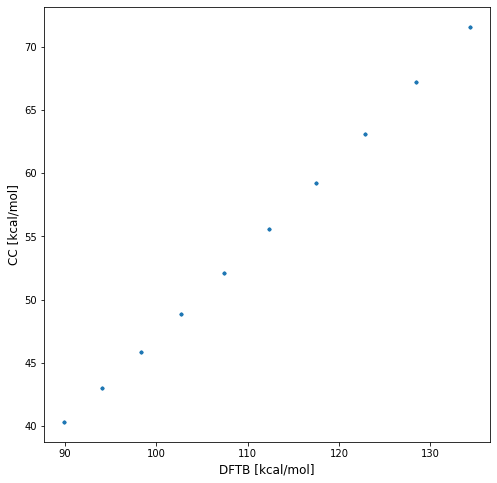

In [58]:
plt.figure(figsize=(8,8))
plt.scatter(md_dftb_ref_e_arr, md_pbe_ref_e_arr,s=7)
plt.xlabel('DFTB [kcal/mol]', fontsize = 12)
plt.ylabel('CC [kcal/mol]', fontsize = 12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


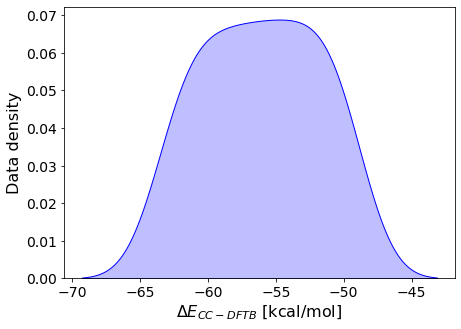

In [55]:
plt.figure(figsize=(7,5))
import seaborn as sns
sns.distplot(md_rel_energy_arr,hist = False, color='blue',kde = True,kde_kws = {'shade': True})
#sns.distplot(b,hist = False, color='red',kde = True,kde_kws = {'shade': True},label='Final dataset')

plt.xlabel('$\Delta E _{CC-DFTB}$ [kcal/mol]',fontsize=16)
plt.ylabel('Data density', fontsize = 16)
plt.tick_params(axis='both', labelsize=14)



# Encode the Molecular Structure

While in Atomic Simulation Environment, the molecule is saved in terms of its xyz coordinates. For the neural network to work, the molecule needs to be converted into all of its distances and record all of its elements.

    
*   distances saves all the distances between each individual atoms.
*   at_idx_map saves all the atom indices that have the same element.



In [ ]:
nAtoms, xyzArr = xyzArr_generator(md_train_arr)

# Calculate distance dataframe from xyz coordinates
distances = src_nogrd.distances_from_xyz(xyzArr, nAtoms)
distances.head()
print(distances.shape)

#enlist the elements
SUPPORTED_ELEMENTS = ['C','H','S']

at_idx_map = at_idx_map_generator(md_train_arr[0])
print(at_idx_map)
#print(at_idx_map_naive)

distances.max

(30, 105)
{'H': array([ 2,  3,  4,  7,  8,  9, 12, 13, 14]), 'C': array([ 0,  5, 10]), 'S': array([ 1,  6, 11])}


<bound method DataFrame.max of       (0, 1)    (0, 2)    (0, 3)  ...  (12, 13)  (12, 14)  (13, 14)
0   1.841822  1.089281  1.087085  ...  1.770497  1.773568  1.770998
1   1.841822  1.089281  1.087085  ...  1.770492  1.773568  1.770998
2   1.841822  1.089281  1.087085  ...  1.770500  1.773564  1.770989
3   1.841822  1.089281  1.087085  ...  1.770495  1.773566  1.770998
4   1.841822  1.089281  1.087085  ...  1.770490  1.773566  1.770998
5   1.841822  1.089281  1.087085  ...  1.770498  1.773569  1.770998
6   1.841822  1.089281  1.087085  ...  1.770500  1.773564  1.770989
7   1.841822  1.089281  1.087085  ...  1.770488  1.773564  1.770998
8   1.841822  1.089281  1.087085  ...  1.770496  1.773567  1.770998
9   1.841822  1.089281  1.087085  ...  1.770498  1.773569  1.770998
10  1.841822  1.089281  1.087085  ...  1.770497  1.773568  1.770998
11  1.841822  1.089281  1.087085  ...  1.770492  1.773568  1.770998
12  1.841822  1.089281  1.087085  ...  1.770500  1.773564  1.770989
13  1.841822  1.0

##  Generate the symmetry function vector ##
Symmetry Function is calculated from the Cartesian xyz coordinate and the element type of the individual atom. 

The radial and angular components of the symmetry functions (Gfuncs)
$$G_{i}^{\text{rad}} = \sum_{j \neq i} 
e^{-
\eta (R_{ij}-R_s)^2} 
$$

$$
G_{i}^{\text{ang}} = 2^{1-\zeta}\sum_{j \neq i} \sum_{k \neq i, j}  
 (1+\lambda \cos \theta_{ijk})^\zeta
e^{-\eta' (R_{ij}^2 + R_{ik}^2 + R_{jk}^2)} 
$$

A set of paramters, $(\eta, R_s)_{\text{rad}}$ and $(\zeta, \lambda, \eta')_{\text{ang}}$, characterized each set of features must be chosen to balance between the accuracy and the performance of the model.

Set Parameters for the Symmetry Functions

The parameters will be saved in the structure Gparam_dict to search for the symmetry function.

WARNING!! Don't change the position of the hyperparameters in the array. The simplified routine are calculated based on that. Change the way the array is constructed is allows. But ang_params must always have [eta, zeta, lambd]

In [ ]:
# radial symmetry function parameters
# Need to automate the Rs_array part
cutoff_rad = 5
#Rs_array = np.linspace(0.8, 5, num=24)   # based on max and min of the distances
Rs_array = np.linspace(0.2, 5, num=15)   # based on max and min of the distances
eta_array = 5/(2.0*np.square(0.2*Rs_array))
rad_params = np.array([(Rs_array[i], eta_array[i], cutoff_rad) for i in range(len(Rs_array)) ])



# angular symmetry function parameters
cutoff_ang = 4
lambd_array = np.array([-1, 1])
#zeta_array = np.array([1, 4, 16])
zeta_array = np.array([4,16])
#eta_ang_array = np.array([0.001, 0.01, 0.05])
eta_ang_array = np.array( [0.001, 0.05])
    
# Each of the element need to be parametrized for all of the list. 
angList = np.array([e1+e2 for e1, e2 in comb_replace(SUPPORTED_ELEMENTS, 2)])
print(angList)
ang_comp = {el : angList for el in SUPPORTED_ELEMENTS}
ang_params = np.array([[eta, zeta, lambd, cutoff_ang] for eta in eta_ang_array for zeta in zeta_array for lambd in lambd_array])

Gparam_dict = {}
for at_type in at_idx_map.keys():
   Gparam_dict[at_type] = {}
   Gparam_dict[at_type]['rad'] = {}
   for at2_rad in at_idx_map.keys():
           Gparam_dict[at_type]['rad'][at2_rad] = rad_params

   # This Section is already designed to be general
   Gparam_dict[at_type]['ang'] = {}
   for at23_ang in ang_comp[at_type]:
       Gparam_dict[at_type]['ang'][at23_ang] = ang_params
for at_type in Gparam_dict.keys():
   print(Gparam_dict[at_type]['rad'].keys())

['CC' 'CH' 'CS' 'HH' 'HS' 'SS']
dict_keys(['H', 'C', 'S'])
dict_keys(['H', 'C', 'S'])
dict_keys(['H', 'C', 'S'])


Save the symmetry fucntion vectors

In [ ]:
path = "/content/tutorial/src"
rad_name = "symFunc_rad.param"
ang_name = "symFunc_ang.param"
with open(os.path.join(path, rad_name), "w") as rad_f:
        rad_f.write(str(cutoff_rad)+"\n")
        for dist, eta in zip(Rs_array, eta_array):
            rad_f.write(f"{dist} {eta}\n")

with open(os.path.join(path, ang_name), "w") as ang_f:
        ang_f.write(str(cutoff_ang)+"\n")
        for row in ang_params:
            ang_f.write(f"{row[0]} {row[1]} {row[2]}\n")

Print your angular and radial parameters

In [ ]:
print()
print()

Generate the symmetry function vectors

In [ ]:
Gfunc_data = src_nogrd.symmetry_function(distances, at_idx_map, Gparam_dict)


Visualize The Symmetry Function Vector

30 93


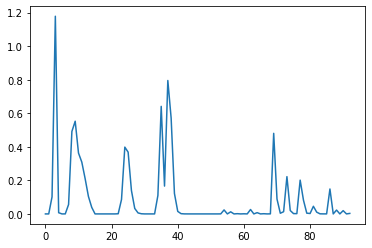

(30, 93)


In [ ]:
sym_func_show(Gfunc_data, 'C', 0, 0)
print(Gfunc_data['C'][0].shape)

In [ ]:
os.mkdir("/content/tutorial/model_2B_nUnit")
os.mkdir("/content/tutorial/data_model")

In [ ]:
# Glboal Var
n_samples = len(md_train_arr)

#input_dim_list = {}
#for at_type in at_idx_map:
#    input_dim_list[at_type] = (n_symm_func, 1)

How many inputs do you have?

In [ ]:
n_symm_func = Gfunc_data['C'][at_idx_map['C'][0]].shape[1]
print(n_symm_func)

93


In [ ]:
builder = netBuilder(SUPPORTED_ELEMENTS, n_symm_func)

In [ ]:
subnets = builder.build_subnets(n_dense_layers=2, n_units=15, 
                      hidden_activation='tanh',
                      dropout_type="NoFirstDrop", dropout_ratio=0.015)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model = builder.build_molecular_net(at_idx_map, subnets)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
H-2-ele (InputLayer)            (None, 93)           0                                            
__________________________________________________________________________________________________
H-3-ele (InputLayer)            (None, 93)           0                                            
__________________________________________________________________________________________________
H-4-ele (InputLayer)            (None, 93)           0                                            
__________________________________________________________________________________________________
H-7-ele (InputLayer)            (None, 93)           0                                            
__________________________________________________________________________________________________
H-8-ele (I

In [ ]:
def idx_generator(n_samples, val_ratio, test_ratio):
    """
    Function:
    Randomly shuffle the indexes and to generate indexes for the training, validation and test set.
    
        Args:
            n_samples: number of samples, an interger
            val_ratio: ratio of the validation set (compared with all data set)
            test_ratio: 
    
        Warning: 0 < val_ratio + test_ratio < 1.
    
        Output:
            train_idx: indexes for training set
            val_idx: indexes for the validation set
            test_idx: indexes for the test set    
    """
    if val_ratio + test_ratio >= 1 or val_ratio + test_ratio <= 0:
        raise  ValueError("idx_generator: the val_ratio and test_ratio must be in between 0 and 1")
    
    shuffled_indices = np.random.permutation(n_samples)
    
    
    val_set_size = int(n_samples * val_ratio)
    val_idx  = shuffled_indices[:val_set_size]
    
    test_set_size= int(n_samples * val_ratio)
    test_idx = shuffled_indices[val_set_size:val_set_size+test_set_size]
    
    train_idx = shuffled_indices[val_set_size + test_set_size:]
    
    return train_idx, val_idx, test_idx
    


Divide your test set in 80% training, 10% validation and 10% test set. What is the purpuse of this?

In [ ]:
## Split the Training, Validation & Test Data 
n_samples = len(md_train_arr)
train_idx, val_idx, test_idx = idx_generator(n_samples, 0.1,0.1)
print(train_idx.shape)
print(val_idx.shape)
# Check whether it is totally splitted
if train_idx.shape[0] + test_idx.shape[0] + val_idx.shape[0] != n_samples:
    raise ValueError("Splitting Test does not equal to the entire set!")

(24,)
(3,)


In [ ]:
y_train = md_rel_energy_arr[train_idx] 
y_val   = md_rel_energy_arr[val_idx]
y_test  = md_rel_energy_arr[test_idx]

print('y_train min, max = ', '%.5f  %.5f' %(y_train.min(), y_train.max() ))
print('y_test min, max = ', '%.5f  %.5f' %(y_test.min(), y_test.max()) )

y_train min, max =  -62.78700  -49.61330
y_test min, max =  -62.78700  -49.61330


In [ ]:
def split_training_data(Feat_data, at_idx_map, train_idx, val_idx, test_idx):
    """
    Function:
    Split the training set, 
        
    Input:
    Feat_data_train: Strucutre for the feat data Feat_data_train['element'][atom]
    at_idx_map: Atom Index Map
    train_idx: the indices used for the training 
    
    
    Output:
    Return the Feat_train, Feat_val and Feat_test set in the shape
    Feat_scaler['element'][atom][Feature Number]    
    """
    
    
    Feat_train_scaled = {}
    Feat_val_scaled = {}
    Feat_test_scaled = {}

    
    for at_type in at_idx_map.keys():
        Feat_train_scaled[at_type] = {}
        Feat_val_scaled[at_type] = {}
        Feat_test_scaled[at_type] = {}
        
        for at in at_idx_map[at_type]:
            Feat_train_scaled[at_type][at] = Feat_data[at_type][at][train_idx,]
            #import pdb; pdb.set_trace()
            Feat_val_scaled[at_type][at]   = Feat_data[at_type][at][val_idx,]
            Feat_test_scaled[at_type][at]  = Feat_data[at_type][at][test_idx,]
            

            
    
    return Feat_train_scaled, Feat_val_scaled, Feat_test_scaled

In [ ]:
train_scaled, val_scaled, test_scaled = split_training_data(Gfunc_data, at_idx_map, train_idx, val_idx, test_idx)
print(test_scaled['C'][0].shape)
#Feat_train_scaled, Feat_val_scaled, Feat_test_scaled = split_training_data(Feat_data, at_idx_map, train_idx, val_idx, test_idx)
#print(Feat_train_scaled['H'][4].shape)

inp_train = []
inp_val   = []
inp_test  = []
for at_type in at_idx_map.keys():

    for atA in at_idx_map[at_type]:
        inp_train.append(train_scaled[at_type][atA])
        #inp_train.append(Feat_train_scaled[at_type][atA])
        
        inp_val.append(val_scaled[at_type][atA])
        #inp_val.append(Feat_val_scaled[at_type][atA])
        
        inp_test.append(test_scaled[at_type][atA])
        #inp_test.append(Feat_test_scaled[at_type][atA])

(3, 93)


In [ ]:
def get_inp(at_idx_map, Gfunc_scaled, Feat_scaled):
    inp_arr = []
    for at_type in at_idx_map.keys():
        for at_idx in at_idx_map[at_type]:
            inp_arr.append(Gfunc_scaled[at_type][at_idx])
            inp_arr.append(Feat_scaled[at_type][at_idx])
    
    return pd.Series(inp_arr)

In [ ]:
from keras.callbacks import ModelCheckpoint
model_folder = "/content/tutorial/model_2B_nUnit"
trainer = netTrainer(model, verbose=1, folder=model_folder)
nUnit = 15

check1 = model_folder +'/' + str(nUnit) + '.hdf5'
checkpointer = ModelCheckpoint(filepath=check1, verbose=0,  monitor='val_mean_squared_error',\
                               mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_mean_squared_error', mode='min', patience=100, verbose=0)


Training Session 1: Learning Rate 0.005


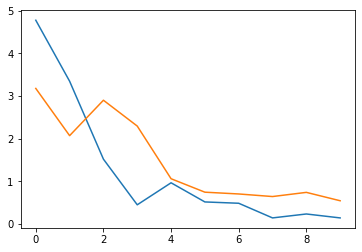

In [ ]:
print("Training Session 1: Learning Rate", 5e-3)
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=5e-3,decay=1e-5),
              metrics=['mean_squared_error', 'mean_absolute_error'])

history = model.fit(inp_train, y_train, \
                    callbacks=[checkpointer, earlystop],
                    batch_size=5, epochs=10, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )

plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.show()

Training Session 2: Learning Rate 0.0005


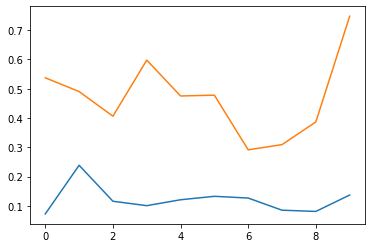

In [ ]:
print("Training Session 2: Learning Rate", 5e-4)
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=5e-4,decay=1e-5),
              metrics=['mean_squared_error', 'mean_absolute_error'])

history2 = model.fit(inp_train, y_train, \
                     callbacks=[checkpointer, earlystop],
                    batch_size=5, epochs=10, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )

plt.plot(history2.history['val_mean_squared_error'])
plt.plot(history2.history['mean_squared_error'])
plt.show()

Training Session 3: Learning Rate 0.0001


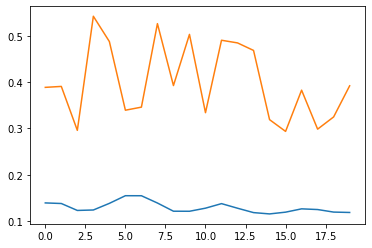

In [ ]:
print("Training Session 3: Learning Rate", 1e-4)
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=1e-4,decay=1e-5),
              metrics=['mean_squared_error', 'mean_absolute_error'])

history3 = model.fit(inp_train, y_train, \
                     callbacks=[checkpointer, earlystop],
                    batch_size=10, epochs=20, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )

plt.plot(history3.history['val_mean_squared_error'])
plt.plot(history3.history['mean_squared_error'])
plt.show()

Training Session 4: Learning Rate 5e-05


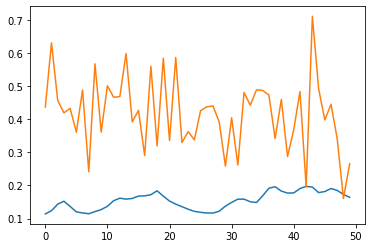

In [ ]:
print("Training Session 4: Learning Rate", 5e-5)
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=5e-5,decay=1e-5),
              metrics=['mean_squared_error', 'mean_absolute_error'])


history4 = model.fit(inp_train, y_train, \
                     callbacks=[checkpointer, earlystop],
                    batch_size=5, epochs=50, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )

plt.plot(history4.history['val_mean_squared_error'])
plt.plot(history4.history['mean_squared_error'])
plt.show()

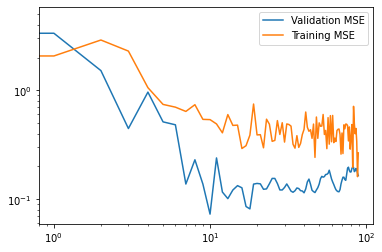

In [ ]:
plt.loglog(history.history['val_mean_squared_error'] + history2.history['val_mean_squared_error'] \
           + history3.history['val_mean_squared_error']+ history4.history['val_mean_squared_error'] \
           , label='Validation MSE')
plt.loglog(history.history['mean_squared_error'] + history2.history['mean_squared_error']\
           + history3.history['mean_squared_error']+ history4.history['mean_squared_error'] \
           , label='Training MSE')
plt.legend()
plt.show()

In [ ]:
!pip install q h5py==2.10.0

In [ ]:
# Load model weights
model.load_weights(check1)

# Error on TEST set 
y_pred_scaled = model.predict(inp_test)
y_pred = y_pred_scaled.T[0]  # in kcal/mol unit
y_obs = y_test #/Eunit

err_test = np.sqrt(mean_squared_error(y_pred, y_obs))
errAbs_test = mean_absolute_error(y_pred, y_obs) 
print('RMSE_test:', '%.4f' % err_test)
print('MAE_test:','%.4f' % errAbs_test)

RMSE_test: 0.4336
MAE_test: 0.3945


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


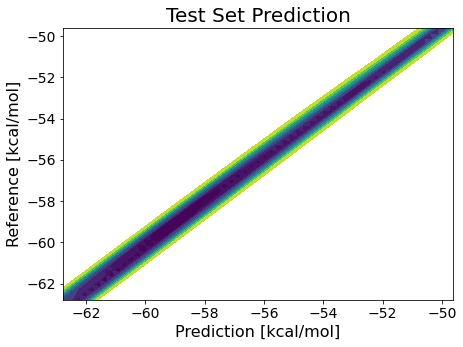

In [ ]:
#print('The mean value of energies in test set: ', '%.4f' %E_ref_orig[test_idx].mean())

# Scatter plot of predicted and true values of energies in the test set
x2 = pd.Series(y_pred, name="Predicted")
x1 = pd.Series(y_obs, name="Observed")

plt.figure(figsize=(7,5))
#plt.plot(x, x, dashes=[10, 5, 20, 5],color='navy',linewidth=1)
ax=sns.kdeplot(x2,x1, cmap='viridis_r',shade=True, shade_lowest=False)
plt.title('Test Set Prediction', fontsize=20)
plt.ylabel('Reference [kcal/mol]', fontsize = 16)
plt.xlabel('Prediction [kcal/mol]',fontsize = 16)
plt.tick_params(axis='both', labelsize=14)
plt.xlim([min(y_obs), max(y_obs)])
plt.ylim([min(y_obs), max(y_obs)])
plt.savefig("TestSetPO", dpi=300)

In [61]:
for el in SUPPORTED_ELEMENTS:
    nm = f"{el}-subnet"
    write_subnet_text(model, save_dir, nm)